# Toy example, compare MLP and Ensemble CIPL

## Generate Data

<IPython.core.display.Javascript object>


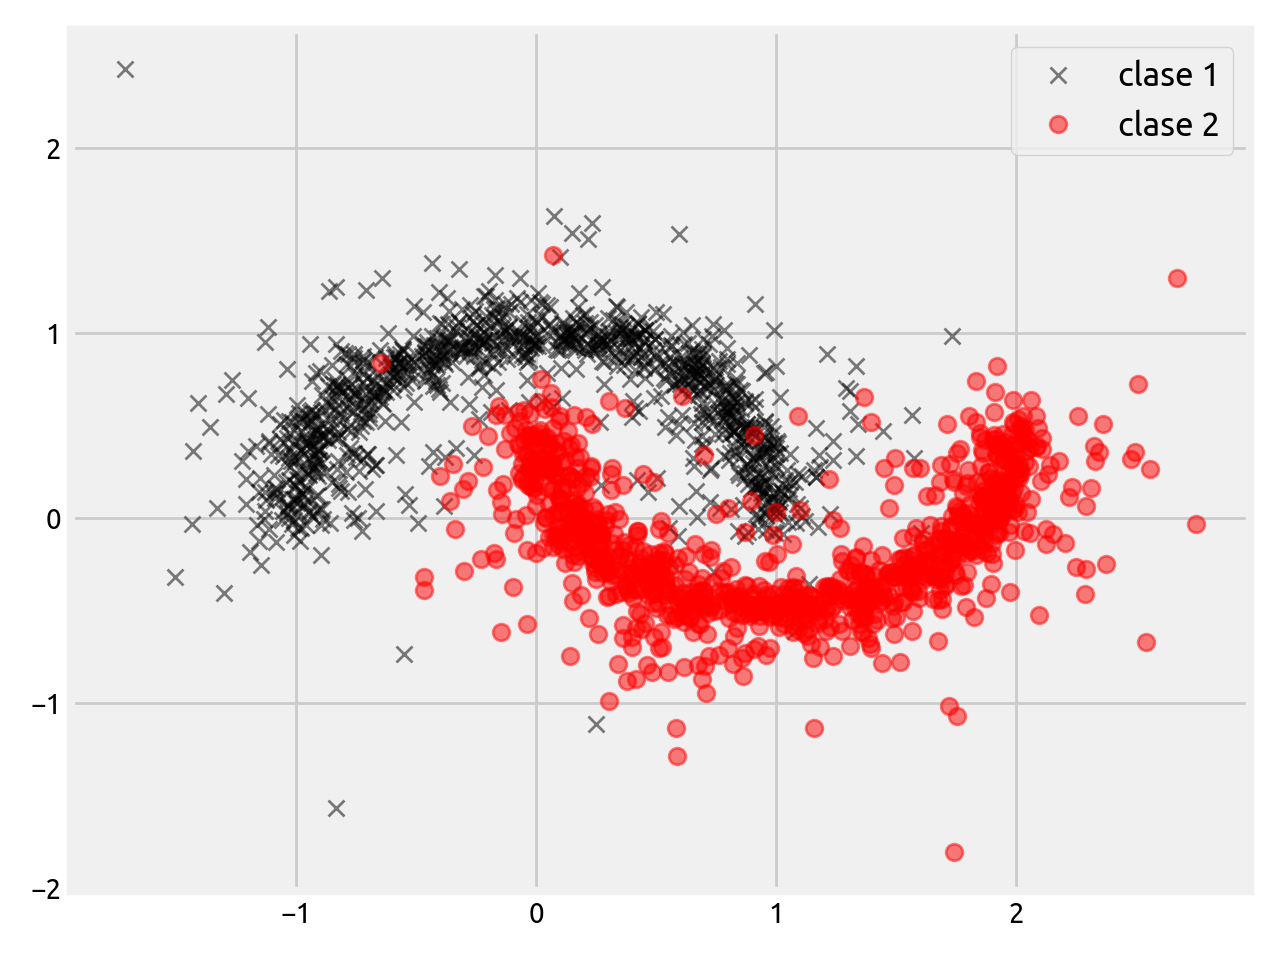

Silverman: 0.4964


In [241]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import scipy

import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../../'))

from config_test import *

from sklearn import model_selection, svm, cross_validation, cluster, datasets
from matplotlib.pyplot import *
from theano import shared, config
import numpy as np

from deepensemble.metrics import *
from deepensemble.utils import *

data_noise = [(500, 0.05), (1000, 0.1), (500, 0.3), (25, 0.6), (10, 0.9)]

X = []
y = []

for n_samples, noise in data_noise:
    X0, y0 = datasets.make_moons(n_samples=n_samples, noise=noise)
    X.append(X0)
    y.append(y0)

X = np.concatenate(X)
y = np.concatenate(y)

x1_samples = X[y==0, :]
x2_samples = X[y==1, :]

plt.plot(x1_samples[:, 0], x1_samples[:, 1], 'kx', alpha=0.5)
plt.plot(x2_samples[:, 0], x2_samples[:, 1], 'ro', alpha=0.5)

classes_names = [0, 1]
labels = ['clase 1', 'clase 2']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.4,
                                                                     random_state=13, stratify=y)

X_train = np.array(X_train, dtype=config.floatX)
X_test = np.array(X_test, dtype=config.floatX)
y_train = np.array(y_train, dtype=config.floatX)
y_test = np.array(y_test, dtype=config.floatX)

plt.legend(labels)
plt.tight_layout()

s = ITLFunctions.silverman(shared(np.array(y))).eval()

print('Silverman: %0.4g' % s)

## Training MLP

In [242]:
import os
import sys

sys.path.insert(0, os.path.abspath('../..'))

from deepensemble.models.sequential import Sequential
from deepensemble.layers.dense import Dense
from deepensemble.utils import *
from deepensemble.metrics import *
import theano.tensor as T

# create MLP
mlp = Sequential("mlp", "classifier", classes_names)
mlp.add_layer(Dense(n_input=X.shape[1], n_output=20, activation=T.tanh))
mlp.add_layer(Dense(n_output=len(classes_names), activation=T.nnet.sigmoid))
mlp.append_cost(mse, name='MSE')
mlp.set_update(sgd, name='SGD', learning_rate=0.2)
mlp.compile(fast=True)

max_epoch = 500  # max epoch training

metrics_mlp = FactoryMetrics.get_metric(mlp)

metric = mlp.fit(X_train, y_train, max_epoch=max_epoch, batch_size=32, early_stop=False)

metrics_mlp.append_prediction(X_test, y_test, append_last_pred=True)
metrics_mlp.append_metric(metric)

metrics_mlp.classification_report()

Comienza la compilación mlp  - elapsed: 0.31 [s]
mlp - fold: 1, epoch:[####################] 500/500 elapsed: 5.15[s] - left: 0.00[s] | score: 0.9724 / 0.9688
Classification Report:
----------------------------------------------------------------------------
           Precision  Recall     f1 Score   Support    
----------------------------------------------------------------------------
0          98.24 +-0.00      96.07 +-0.00      97.14 +-0.00      407               
1          96.15 +-0.00      98.28 +-0.00      97.21 +-0.00      407               
----------------------------------------------------------------------------
average:   97.20 +-0.00      97.17 +-0.00      97.17 +-0.00      
----------------------------------------------------------------------------



<IPython.core.display.Javascript object>


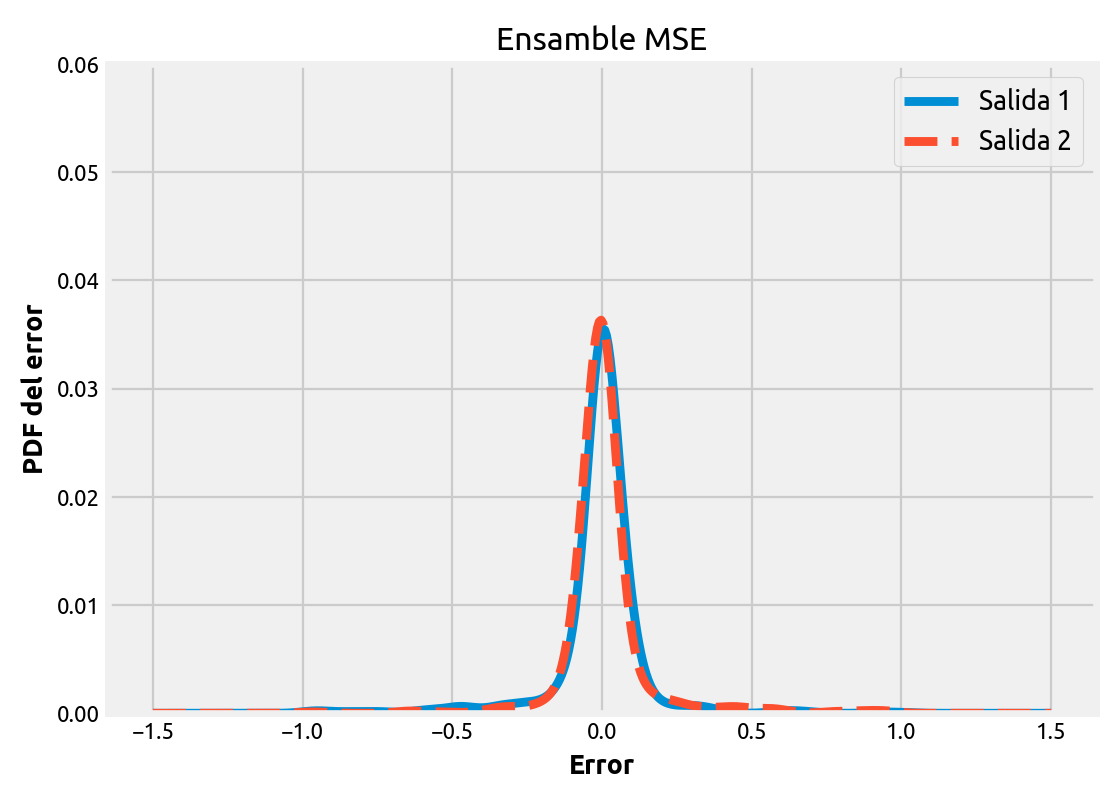

In [243]:
fig = plt.figure(figsize=(7, 5), dpi=80)

ax = fig.add_subplot(1, 1, 1)
plot_pdf_error(mlp, X_test, y_test, 'Ensamble MSE', ax, fig, lim_y=0.06)

## Training Ensemble

In [244]:
from deepensemble.models.ensemblemodel import EnsembleModel
from deepensemble.combiner import *

n_models = 5

ensemble = get_ensembleCIP_model(name='Ensamble CIPL', classification=True, classes_labels=classes_names,
                                    n_input=X.shape[1], n_output=len(classes_names),
                                    n_ensemble_models=n_models, n_neurons_models=4,
                                    is_cip_full=False,
                                    fn_activation1=T.tanh, fn_activation2=T.nnet.sigmoid,
                                    dist='CS',
                                    beta=0.1, lamb=0.1, s=s,
                                    lsp=1.5, lsm=0.5,
                                    lr=0.001,
                                    bias_layer=False, mse_first_epoch=True, annealing_enable=True,
                                    update=sgd, name_update='SGD',
                                    params_update={'learning_rate': -0.2})
ensemble.compile(fast=True)

metrics_ensemble = FactoryMetrics.get_metric(ensemble)

metric = ensemble.fit(X_train, y_train, max_epoch=max_epoch, batch_size=32, early_stop=False,
                      criterion_update_params='cost', maximization_criterion=True)

metrics_ensemble.append_prediction(X_test, y_test, append_last_pred=True)
metrics_ensemble.append_metric(metric)

metrics_ensemble.classification_report()

Comienza la compilación Ensamble CIPL  - elapsed: 31.78 [s]
Ensamble CIPL - fold: 1, epoch:[####################] 500/500 elapsed: 100.24[s] - left: 0.00[s] | score: 0.9724 / 0.9792
Classification Report:
----------------------------------------------------------------------------
           Precision  Recall     f1 Score   Support    
----------------------------------------------------------------------------
0          98.50 +-0.00      96.81 +-0.00      97.65 +-0.00      407               
1          96.86 +-0.00      98.53 +-0.00      97.69 +-0.00      407               
----------------------------------------------------------------------------
average:   97.68 +-0.00      97.67 +-0.00      97.67 +-0.00      
----------------------------------------------------------------------------



<IPython.core.display.Javascript object>


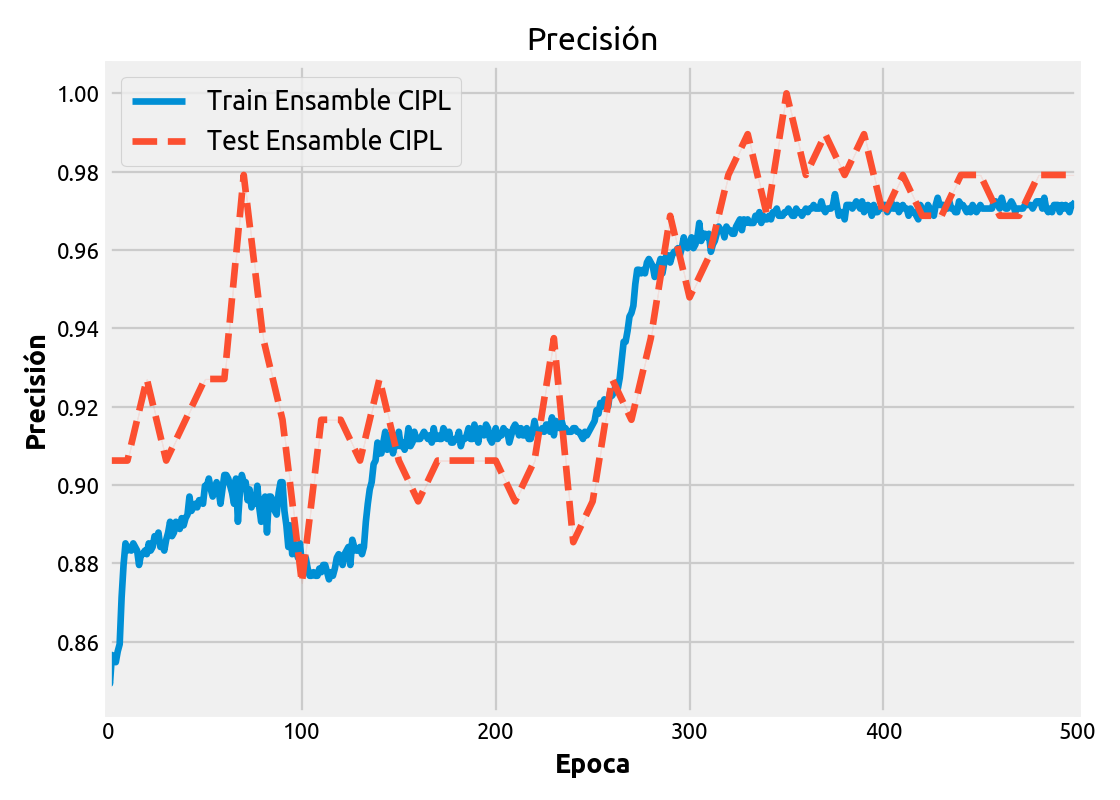

<IPython.core.display.Javascript object>


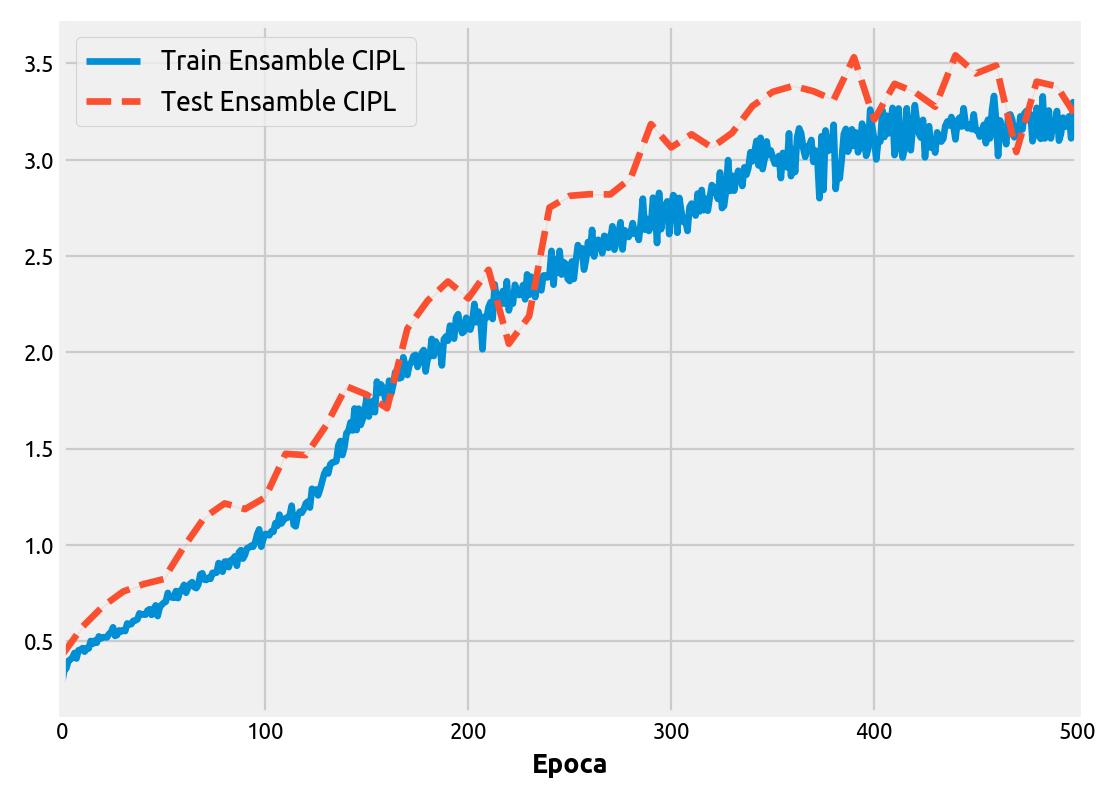

In [245]:
metrics_ensemble.plot_scores(max_epoch=max_epoch, title='')
metrics_ensemble.plot_cost(max_epoch=max_epoch, title='')
plt.show()

## Plot Models Ensemble

<IPython.core.display.Javascript object>


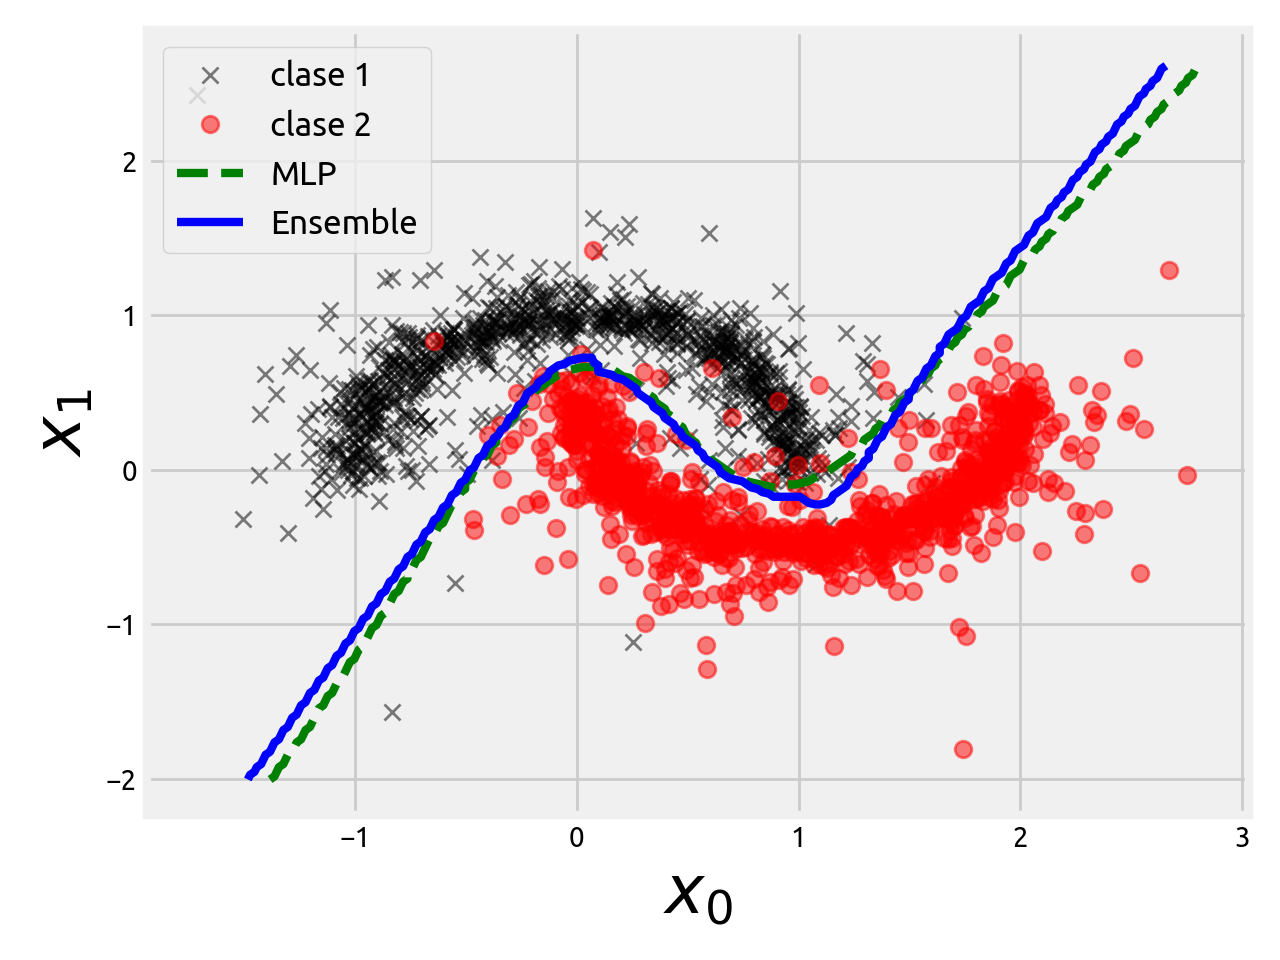

In [246]:
import matplotlib._cntr as cntr

h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x = np.array(np.c_[xx.ravel(), yy.ravel()], dtype=config.floatX)
Z1 = mlp.predict(x)
Z2 = ensemble.predict(x)

# Put the result into a color plot
z1 = Z1.reshape(xx.shape)
z2 = Z2.reshape(xx.shape)

def get_contour(x, y, z):
    c = cntr.Cntr(x, y, z)
    level = 0.5
    nlist = c.trace(level, level, 0)
    segs = nlist[:len(nlist)//2]
    x1 = []
    y1 = []
    for seg in segs:
        x1 = np.concatenate((x1, seg[:,0]))
        y1 = np.concatenate((y1, seg[:,1]))
    return x1, y1


xx1, yy1 = get_contour(xx, yy, z1)
xx2, yy2 = get_contour(xx, yy, z2)

n_sep = 2

fig = plt.figure()
plt.plot(x1_samples[:,0],x1_samples[:,1], 'kx', alpha=0.5)
plt.plot(x2_samples[:,0],x2_samples[:,1], 'ro', alpha=0.5)
plt.plot(xx1[0::n_sep], yy1[0::n_sep], '--g', linewidth=3)
plt.plot(xx2[0::n_sep], yy2[0::n_sep], '-b', linewidth=3)
plt.legend(labels + ['MLP', 'Ensemble'])
plt.xlabel('$x_0$', fontsize=24)
plt.ylabel('$x_1$', fontsize=24)
plt.tight_layout()

<IPython.core.display.Javascript object>


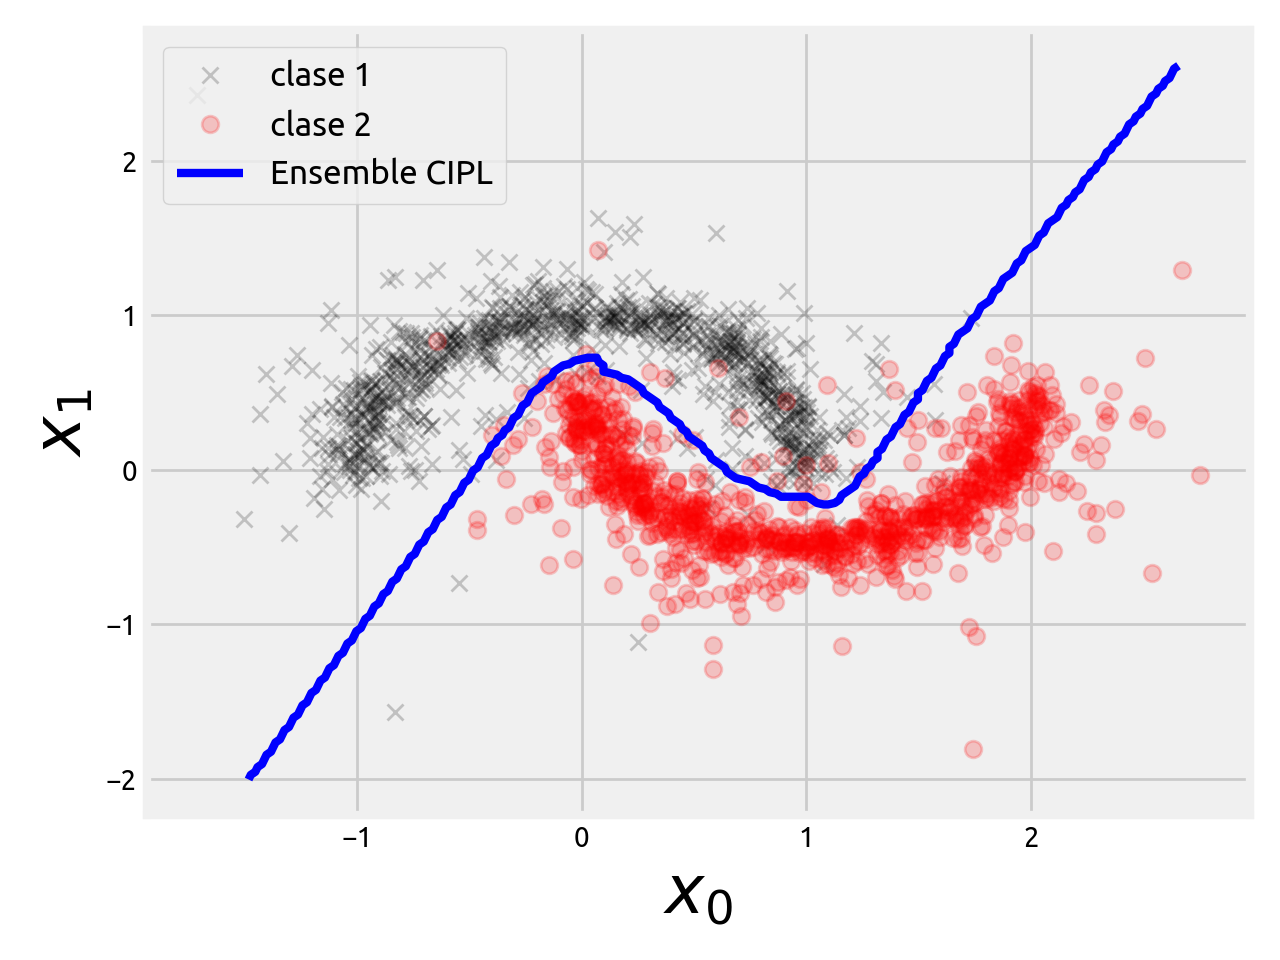

In [258]:
fig = plt.figure()
plt.plot(x1_samples[:,0],x1_samples[:,1], 'kx', alpha=0.2)
plt.plot(x2_samples[:,0],x2_samples[:,1], 'ro', alpha=0.2)
plt.plot(xx2[0::n_sep], yy2[0::n_sep], '-b', linewidth=3)
plt.legend(labels + ['Ensemble CIPL'], loc=2)
plt.xlabel('$x_0$', fontsize=24)
plt.ylabel('$x_1$', fontsize=24)
plt.tight_layout()

<IPython.core.display.Javascript object>


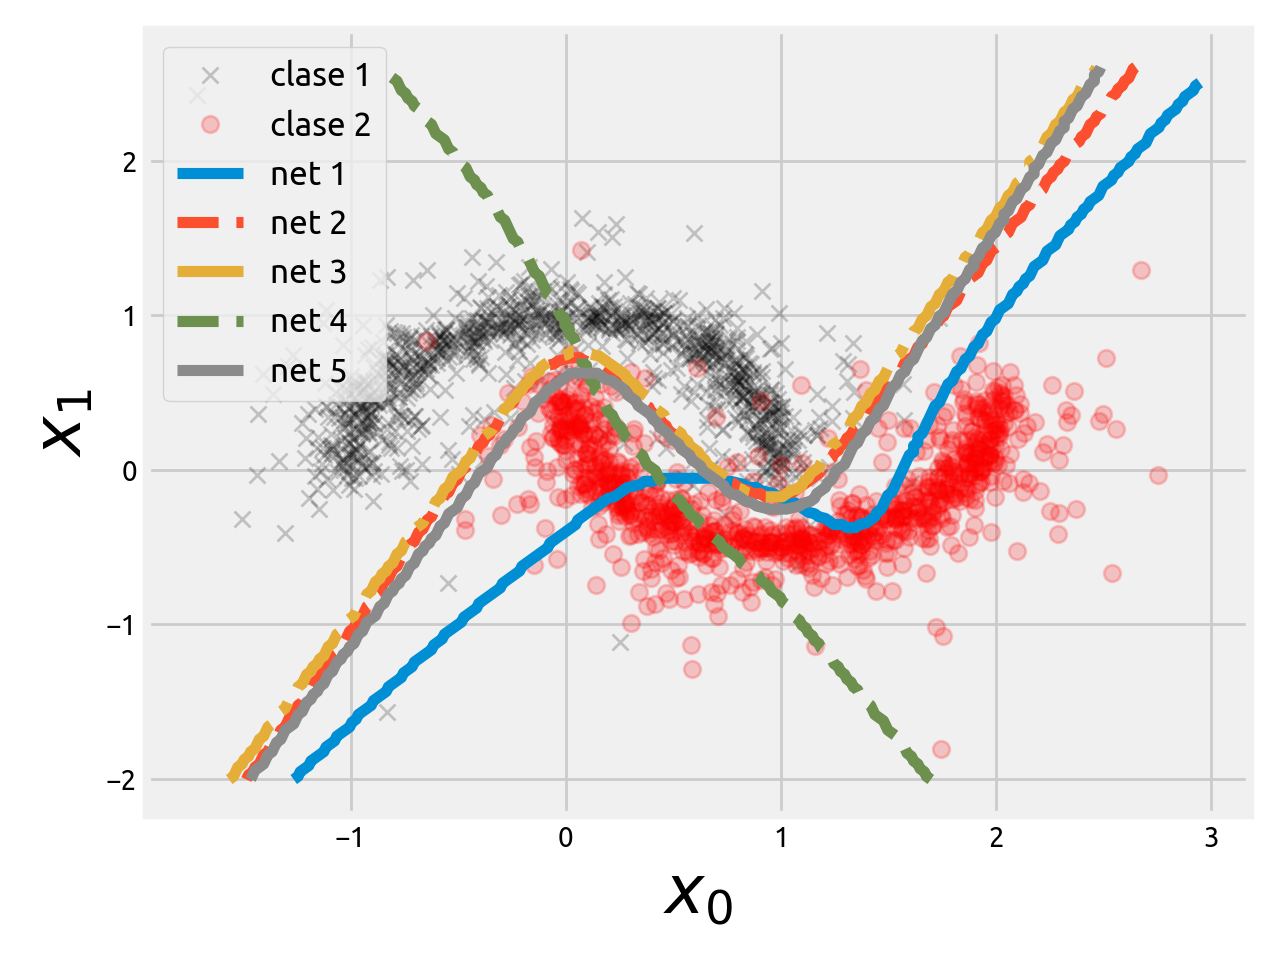

In [257]:
fig = plt.figure()
plt.plot(x1_samples[:,0],x1_samples[:,1], 'kx', alpha=0.2, label=labels[0])
plt.plot(x2_samples[:,0],x2_samples[:,1], 'ro', alpha=0.2, label=labels[1])
linestyles = ['-', '--', '-.', '--']
for i in range(n_models):
    Z1 = ensemble.get_models()[i].predict(x)

    # Put the result into a color plot
    z1 = Z1.reshape(xx.shape)

    xx1, yy1 = get_contour(xx, yy, z1)

    plt.plot(xx1[0::n_sep], yy1[0::n_sep], linestyle=linestyles[(i + 4) % 4], linewidth=4, label='net %d' % (i+ 1))

plt.legend(loc=2)
plt.xlabel('$x_0$', fontsize=24)
plt.ylabel('$x_1$', fontsize=24)
plt.tight_layout()

<IPython.core.display.Javascript object>


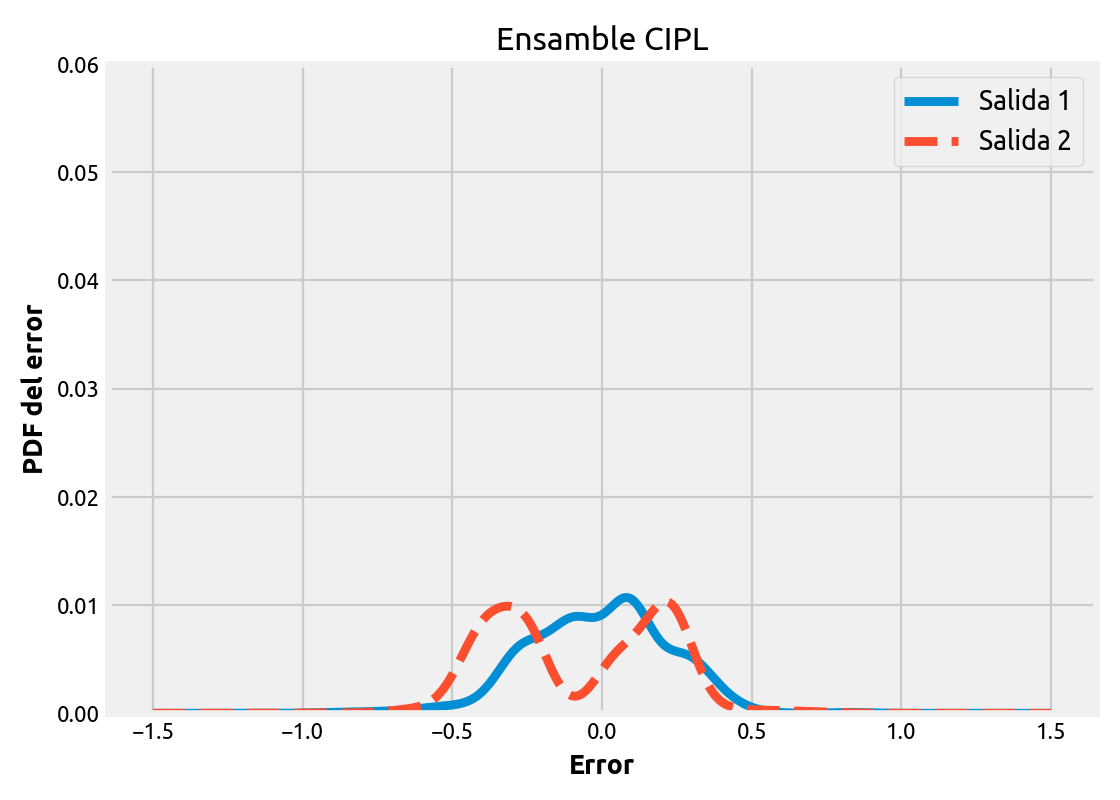

In [249]:
fig = plt.figure(figsize=(7, 5), dpi=80)

ax = fig.add_subplot(1, 1, 1)
plot_pdf_error(ensemble, X_test, y_test, 'Ensamble CIPL', ax, fig, lim_y=0.06)

<IPython.core.display.Javascript object>


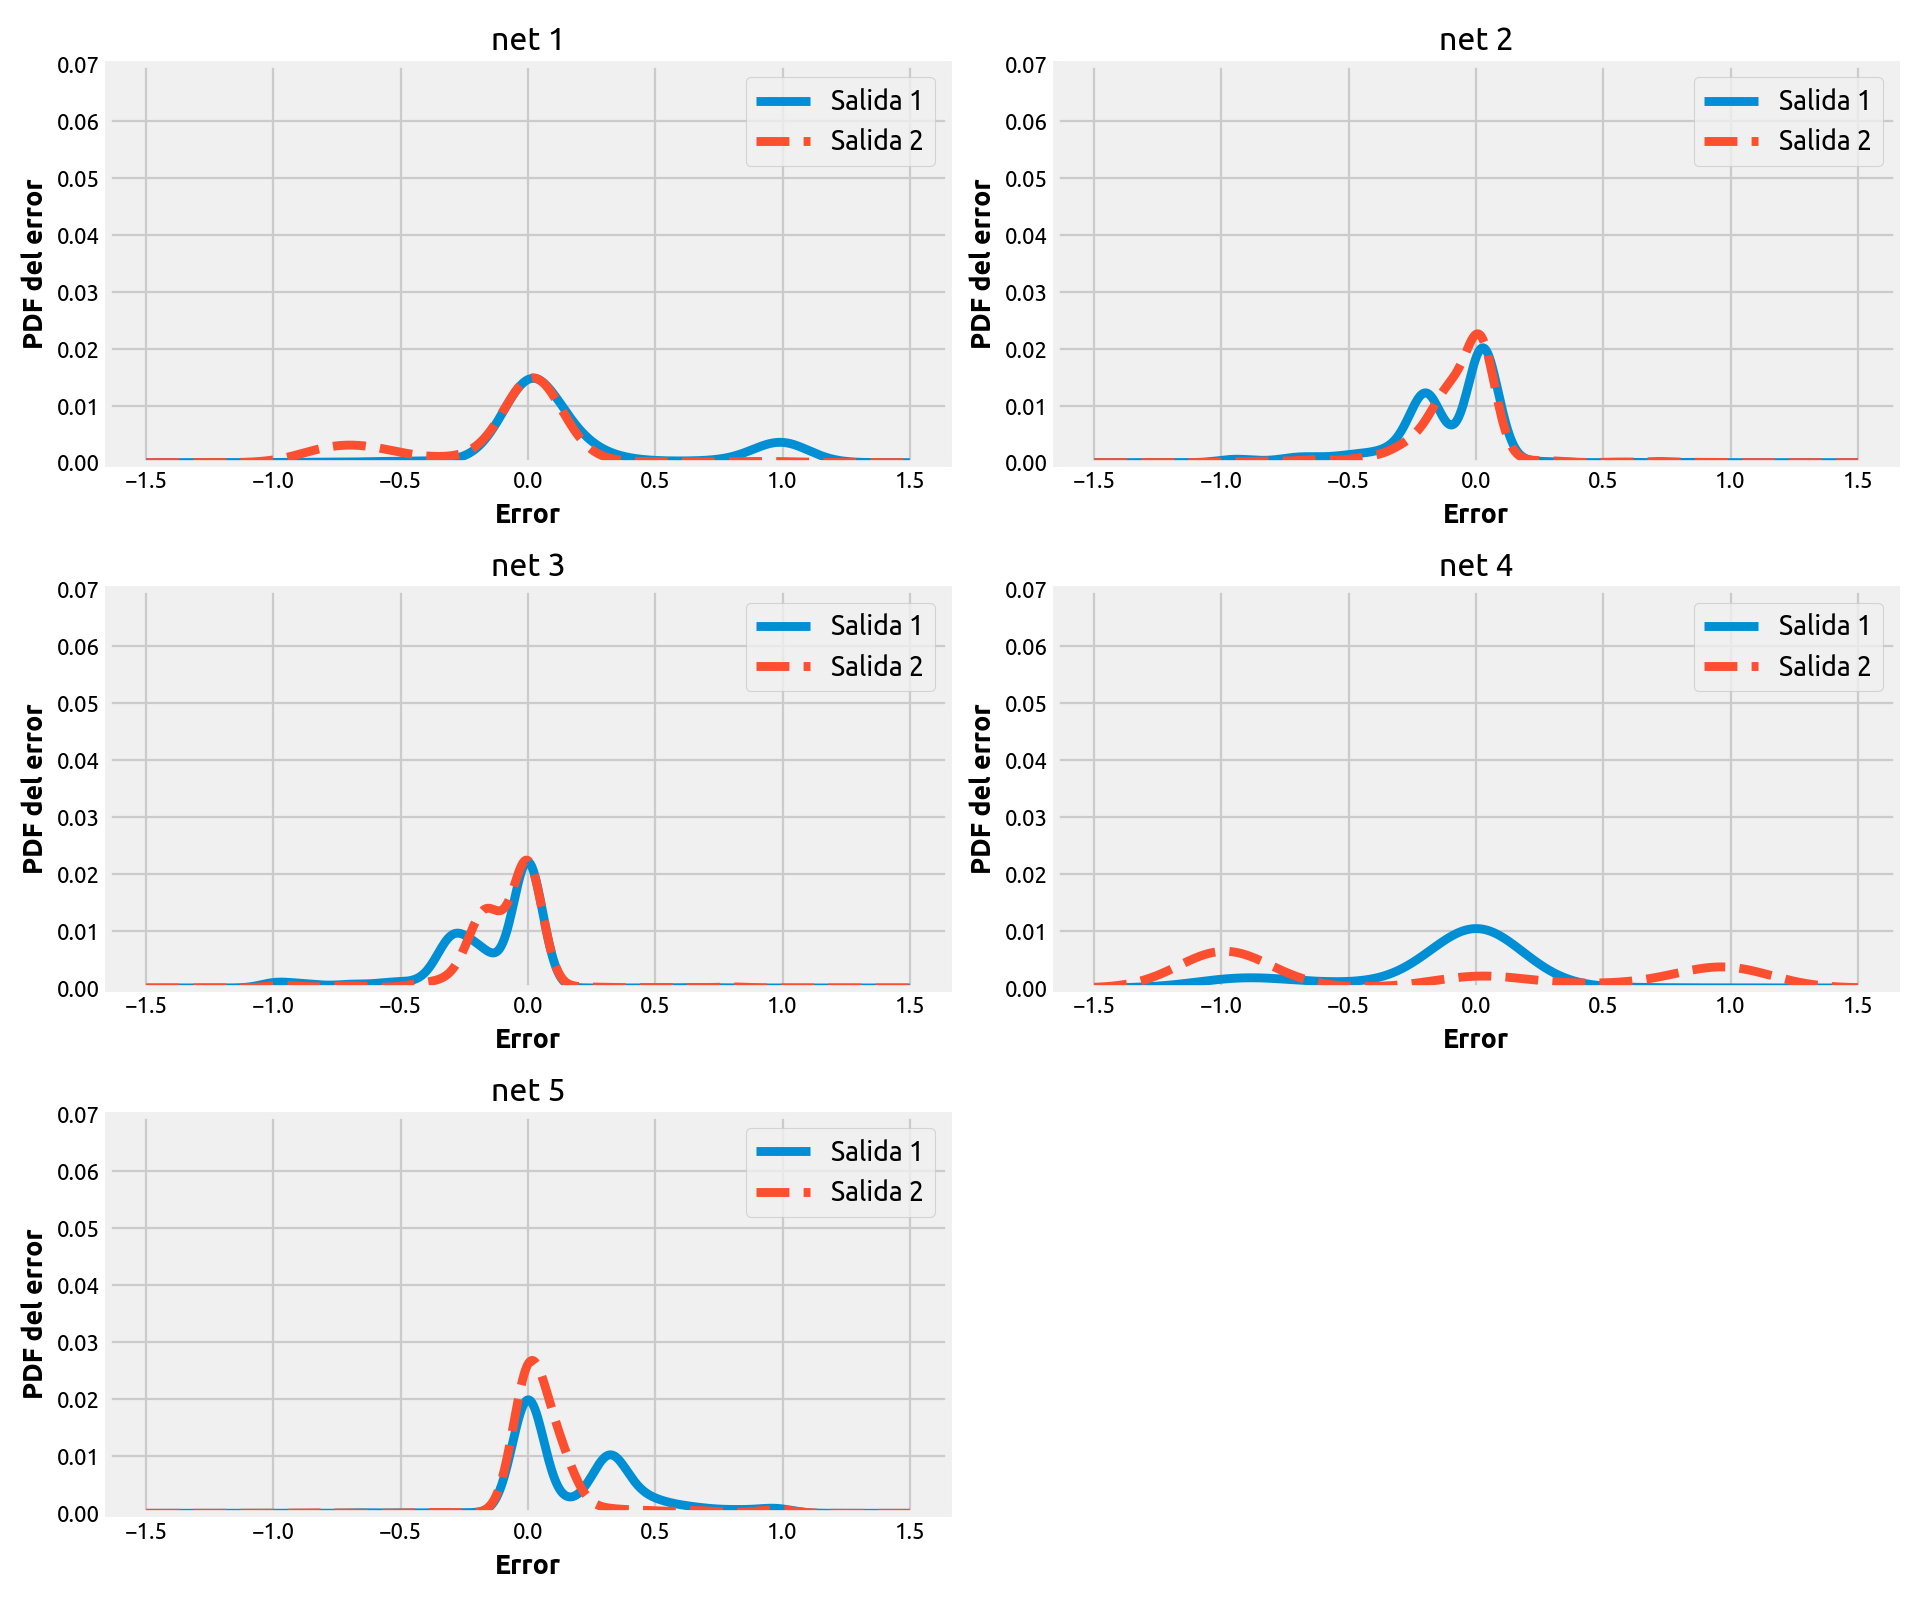

In [250]:
fig = plt.figure(figsize=(12, 5 * (n_models // 2)), dpi=80)
for i in range(n_models):
    ax = fig.add_subplot(n_models // 2 + (n_models % 2), 2, i + 1)
    plot_pdf_error(ensemble.get_models()[i], X_test, y_test, 'net %d' % (i + 1), ax, fig, lim_y=0.07)

In [251]:
print(mlp.get_name())
metrics = FactoryMetrics.get_metric(mlp)
# metrics.append_prediction(X_train, y_train, append_last_pred=True)
metrics.append_prediction(X_test, y_test, append_last_pred=True)
metrics.classification_report()

print(ensemble.get_name())
metrics = FactoryMetrics.get_metric(ensemble)
# metrics.append_prediction(X_train, y_train, append_last_pred=True)
metrics.append_prediction(X_test, y_test, append_last_pred=True)
metrics.classification_report()

for i in range(n_models):
    model = ensemble.get_models()[i]
    print(model.get_name())
    metrics = FactoryMetrics.get_metric(model)
    # metrics.append_prediction(X_train, y_train, append_last_pred=True)
    metrics.append_prediction(X_test, y_test, append_last_pred=True)
    metrics.classification_report()


mlp
Classification Report:
----------------------------------------------------------------------------
           Precision  Recall     f1 Score   Support    
----------------------------------------------------------------------------
0          98.24 +-0.00      96.07 +-0.00      97.14 +-0.00      407               
1          96.15 +-0.00      98.28 +-0.00      97.21 +-0.00      407               
----------------------------------------------------------------------------
average:   97.20 +-0.00      97.17 +-0.00      97.17 +-0.00      
----------------------------------------------------------------------------

Ensamble CIPL
Classification Report:
----------------------------------------------------------------------------
           Precision  Recall     f1 Score   Support    
----------------------------------------------------------------------------
0          98.50 +-0.00      96.81 +-0.00      97.65 +-0.00      407               
1          96.86 +-0.00      98.53 +-0.00  